In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"

In [3]:
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [4]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [7]:
from tensorflow.keras.regularizers import l2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)
# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 501ms/step - accuracy: 0.7639 - loss: 0.5371 - val_accuracy: 0.9420 - val_loss: 0.1552 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 400ms/step - accuracy: 0.9461 - loss: 0.1577 - val_accuracy: 0.9503 - val_loss: 0.1255 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 405ms/step - accuracy: 0.9528 - loss: 0.1285 - val_accuracy: 0.9600 - val_loss: 0.1129 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9609 - loss: 0.1074 - val_accuracy: 0.9630 - val_loss: 0.0995 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.9652 - loss: 0.0980 - val_accuracy: 0.9650 - val_loss: 0.0908 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 415ms/step - accuracy: 0.9694 - loss: 0.0817 - val_accuracy: 0.9697 - val_loss: 0.0836 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step -

In [8]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)



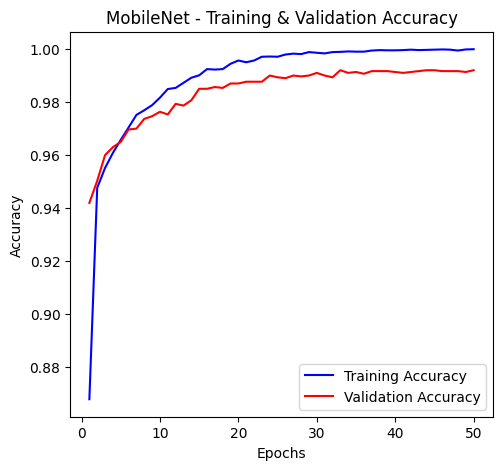

In [9]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet - Training & Validation Accuracy')
plt.legend()



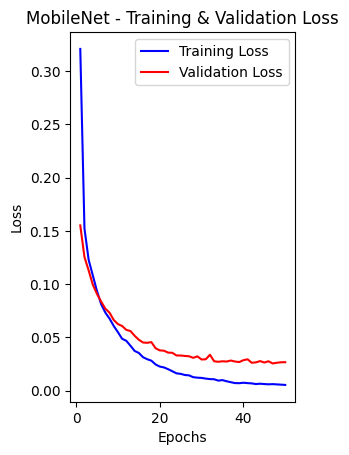

In [10]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet - Training & Validation Loss')
plt.legend()

plt.show()


In [11]:
# Save the entire model (architecture + weights)
model.save("mobilenet_lung_cancer.h5")
print("MobileNet model saved.")

MobileNet model saved.


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Load pre-trained EfficientNetB1 model
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove the original classification head
    weights='imagenet'  # Load pre-trained weights
)

# 🔒 Freeze all layers initially
base_model.trainable = False  

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Adjust to your number of classes
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary to check frozen layers
model.summary()


28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)       │ (None, 7, 7, 1280)          │       6,931,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,095,479 (27.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

In [14]:
# Early stopping & learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Start with a few epochs while frozen
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 565ms/step - accuracy: 0.3381 - loss: 1.1143 - val_accuracy: 0.3750 - val_loss: 1.0982 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 392ms/step - accuracy: 0.3485 - loss: 1.1026 - val_accuracy: 0.3410 - val_loss: 1.0992 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.3474 - loss: 1.1012 - val_accuracy: 0.4070 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 387ms/step - accuracy: 0.3539 - loss: 1.1005 - val_accuracy: 0.3337 - val_loss: 1.0979 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 390ms/step - accuracy: 0.3417 - loss: 1.1007 - val_accuracy: 0.3330 - val_loss: 1.1001 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 390ms/step - accuracy: 0.3433 - loss: 1.0997 - val_accuracy: 0.3333 - val_loss: 1.1002 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 3

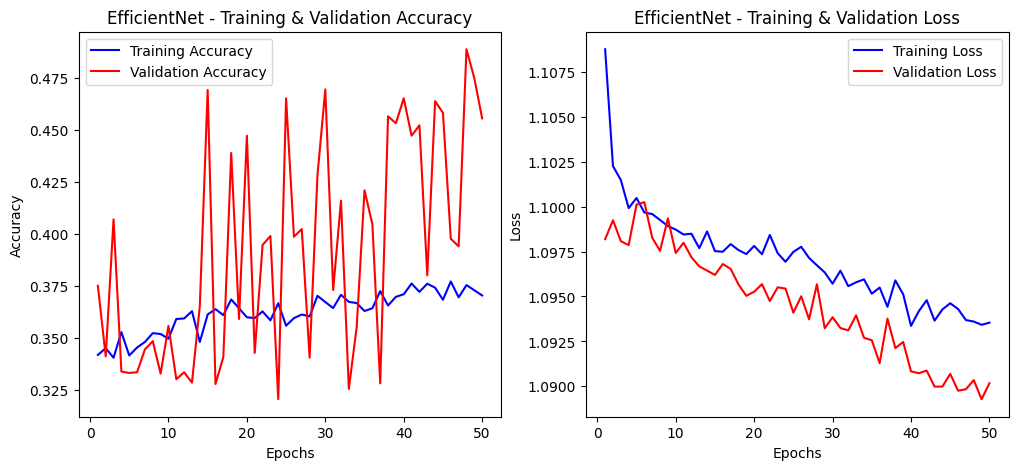

EfficientNet model saved.


In [15]:
#import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EfficientNet - Training & Validation Loss')
plt.legend()

plt.show()

# Save the model
model.save("efficientnet_lung_cancer.h5")
print("EfficientNet model saved.")

In [16]:
#!pip install -q keras-squeezenet
#squeezenet covered in phase X, reference code

In [17]:
"""import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def fire_module(x, squeeze_filters, expand_filters):
    x = layers.Conv2D(squeeze_filters, (1, 1), activation='relu')(x)
    left = layers.Conv2D(expand_filters, (1, 1), activation='relu')(x)
    right = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.concatenate([left, right])
    return x

def build_squeezenet(input_shape=(224, 224, 3), num_classes=3):
    input_img = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Activation('softmax')(x)

    model = models.Model(inputs=input_img, outputs=output)
    return model

# Build SqueezeNet
model = build_squeezenet()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
"""

"import tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.regularizers import l2\n\ndef fire_module(x, squeeze_filters, expand_filters):\n    x = layers.Conv2D(squeeze_filters, (1, 1), activation='relu')(x)\n    left = layers.Conv2D(expand_filters, (1, 1), activation='relu')(x)\n    right = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(x)\n    x = layers.concatenate([left, right])\n    return x\n\ndef build_squeezenet(input_shape=(224, 224, 3), num_classes=3):\n    input_img = tf.keras.Input(shape=input_shape)\n    \n    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(input_img)\n    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)\n\n    x = fire_module(x, 16, 64)\n    x = fire_module(x, 16, 64)\n    x = fire_module(x, 32, 128)\n    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)\n\n    x = fire_module(x, 32, 128)\n    x = fire_module(x, 48, 192)\n    x = fire_modul

In [18]:
"""early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
"""

"early_stopping = tf.keras.callbacks.EarlyStopping(\n    monitor='val_loss',\n    patience=5,\n    restore_best_weights=True\n)\n\nreduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\n    monitor='val_loss', \n    factor=0.5,  \n    patience=3,  \n    min_lr=1e-6\n)\n\nhistory = model.fit(\n    train_data,\n    validation_data=val_data,\n    epochs=50,\n    callbacks=[early_stopping, reduce_lr],\n    verbose=1\n)\n"

In [19]:
"""
#import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SqueezeNet - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SqueezeNet - Training & Validation Loss')
plt.legend()

plt.show()

# Save model
model.save('/kaggle/working/squeezenet_lung_cancer.h5')
print("SqueezeNet model saved.")
"""

'\n#import matplotlib.pyplot as plt\n\n# Extract accuracy and loss values\ntrain_acc = history.history[\'accuracy\']\nval_acc = history.history[\'val_accuracy\']\ntrain_loss = history.history[\'loss\']\nval_loss = history.history[\'val_loss\']\nepochs = range(1, len(train_acc) + 1)\n\n# Plot Accuracy\nplt.figure(figsize=(12, 5))\nplt.subplot(1, 2, 1)\nplt.plot(epochs, train_acc, \'b-\', label=\'Training Accuracy\')\nplt.plot(epochs, val_acc, \'r-\', label=\'Validation Accuracy\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Accuracy\')\nplt.title(\'SqueezeNet - Training & Validation Accuracy\')\nplt.legend()\n\n# Plot Loss\nplt.subplot(1, 2, 2)\nplt.plot(epochs, train_loss, \'b-\', label=\'Training Loss\')\nplt.plot(epochs, val_loss, \'r-\', label=\'Validation Loss\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.title(\'SqueezeNet - Training & Validation Loss\')\nplt.legend()\n\nplt.show()\n\n# Save model\nmodel.save(\'/kaggle/working/squeezenet_lung_cancer.h5\')\nprint("SqueezeNet mode